Number of positions in file 564
array_long_centre 116.7636478
array_lat_centre -26.82408816
Filename used for configuration:  full_array_4a_1m.wgs84.564x4.txt
Number of positions in file 564
Phi is -40.0
elevation is 50.0
elevation is 60.0
elevation is 70.0
Phi is -30.0
elevation is 50.0
elevation is 60.0
elevation is 70.0
Phi is -10.0
elevation is 50.0
elevation is 60.0
elevation is 70.0
Phi is 0.0
elevation is 50.0
elevation is 60.0
elevation is 70.0
Phi is 10.0
elevation is 50.0
elevation is 60.0
elevation is 70.0
Phi is 20.0
elevation is 50.0
elevation is 60.0
elevation is 70.0
Phi is 30.0
elevation is 50.0
elevation is 60.0
elevation is 70.0
Phi is 40.0
elevation is 50.0
elevation is 60.0
elevation is 70.0
Baselines:  3810384
Bins used:  6


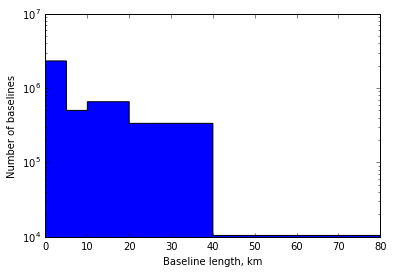

Percentage outputs per bin:  [ 60.65291582  13.12119723  17.16367694   8.78851055   0.27369945]
Bin top edge:  [  5000.  10000.  20000.  40000.  80000.]
[ 2311109.   499968.   654002.   334876.    10429.]
3810384.0
[ 60.65291582  13.12119723  17.16367694   8.78851055   0.27369945]
100.0


In [1]:
import numpy as np
import math
import os
import sys
from pylab import *
import matplotlib.pyplot as plt
%matplotlib inline

def readcol(filename,col_number,comment='#'):
        """
        read in a file
        """
        f    = open(filename,'r')
        line = f.readline()

        column = []
        while line:
                columns = line.split()
                column.append(float(columns[col_number-1]))
                line = f.readline()
        f.close()
        return(column)

telescope='LOW' #choose telescope
use_given_bins=True #either use baseline bins matching those currently in the main parametric model or creat new ones..."
binning_type='linear' #and if you make new ones, have either 'linear' or 'log' spacing. 


if telescope=='LOW':
    #config_reader_file=os.getcwd()+'/Reference_Layouts/LOW_LONG_LAT_ECP.wgs84.753x4.txt'
    config_reader_file=os.getcwd()+'/Reference_Layouts/full_array_4a_1m.wgs84.564x4.txt'
    baseline_bins = np.array((0, 80.0/16.0, 80.0/8.0, 80.0/4.0, 80.0/2.0, 80.0))
    #baseline_bins = np.array((0, 4.9, 7.1, 10.4, 15.1, 22.1, 32.2, 47.0, 80.0))

elif telescope=='MID_OLD':
    config_reader_file=os.getcwd()+'/Reference_Layouts/MID_LONG_LAT_ECP.wgs84.254x4.txt'
    baseline_bins = np.array((0, 4.4, 6.7, 10.3, 15.7, 24.0, 36.7, 56.0, 85.6, 130.8, 150))
elif telescope=='MID':
    config_reader_file=os.getcwd()+'/Reference_Layouts/Rebaselined_15July2015_SKA-SA.wgs84.197x4.txt'
    #baseline_bins = np.array((0, 4.4, 6.7, 10.3, 15.7, 24.0, 36.7, 56.0, 85.6, 130.8, 150))
    baseline_bins = np.array((0, 5, 7.5, 10, 15, 25, 35, 55.0, 75.0, 90.0, 110.0, 130.0, 150))

dish_longitude=readcol(config_reader_file, 2)
dish_latitude=readcol(config_reader_file, 3)
dish_diameter=readcol(config_reader_file, 1)
Rearth=6371010.0/1000.0
Number_positions=int(len(dish_diameter)-1)
print "Number of positions in file", Number_positions

array_long_centre=dish_longitude[Number_positions]
array_lat_centre=dish_latitude[Number_positions]
array_centre_diameter=dish_diameter[Number_positions]

print "array_long_centre", array_long_centre
print "array_lat_centre", array_lat_centre
if array_centre_diameter!=0.0: print "array_centre_diameter", array_centre_diameter, '(should be zero, just a check)'

degtorad=2.0*math.pi/360.0

#get x,y,z cartesian coordinates for positions (assuming they sit on a sphere of radius Rearth)
array_x_centre=Rearth*math.cos(array_lat_centre*degtorad)*math.cos(array_long_centre*degtorad)
array_y_centre=Rearth*math.cos(array_lat_centre*degtorad)*math.sin(array_long_centre*degtorad)
array_z_centre=Rearth*math.sin(array_lat_centre*degtorad)
print "Filename used for configuration: ", os.path.basename(config_reader_file)
print "Number of positions in file", Number_positions
Array_dx=[]
Array_dy=[]
Array_dz=[]
Array_r=[]
Baseline_lengths_uv=[]
for i in range(Number_positions):
	Array_dx.append(Rearth*math.cos(dish_latitude[i]*degtorad)*math.cos(dish_longitude[i]*degtorad)-array_x_centre)
	Array_dy.append(Rearth*math.cos(dish_latitude[i]*degtorad)*math.sin(dish_longitude[i]*degtorad)-array_y_centre)
	Array_dz.append(Rearth*math.sin(dish_latitude[i]*degtorad)-array_z_centre)
	Array_r.append(math.sqrt(Array_dx[i]**2+Array_dy[i]**2+Array_dz[i]**2))
        
"""
UV lenghts only are taken into account, across a range of source elevation and obsering directions, so that the values are average.
But, it is trivial to calculate! File arrangements are as generated by iantconfig (by the very talented Matteiu De Villiers).
see http://public.ska.ac.za/software/iantconfig
"""

phi_degrees=[-40,-30,-10,0,10,20,30,40]
#phi_degrees=[-40]
elevation_degrees=[50,60,70]
#elevation_degrees=[60]

for k in range(len(phi_degrees)):
    phi=phi_degrees[k]/57.3
    print "Phi is", phi*57.3
    for l in range(len(elevation_degrees)):
        elevation=elevation_degrees[l]/57.3
        print "elevation is", elevation*57.3
        for i in range(Number_positions):
            for j in range(Number_positions):
                if j > i:
                    #rotate baselines to phi position (phi=0 means looking eastwards, phi=pi/2 means looking north)
                    #then reduce baseline lengths in direction of view by elevation factor
                    a=(Array_dx[j]-Array_dx[i])*cos(phi) - (Array_dy[j]-Array_dy[i])*sin(phi)
                    b=(Array_dx[j]-Array_dx[i])*sin(phi) + (Array_dy[j]-Array_dy[i])*cos(phi)
                    blength_uv=(math.sqrt((a*sin(elevation))**2 + (b)**2))
                    Baseline_lengths_uv.append(blength_uv)
                                        
                    
#print Baseline_lengths_uv
print "Baselines: ", len(Baseline_lengths_uv)
#print Baseline_lengths_uv[0:1000]

#
# create a histogram by providing the bin edges (unequally spaced)
#

if use_given_bins:
    bins=baseline_bins
else:
 nbins=50
 bmax=0.8
 bmin=0.01
 bin_number=range(nbins)
 bins=bin_number
 for i in range(nbins):
        if binning_type=="log":
            cutoff=bmin*10**(log10(bmax/bmin)*float(i)/float(nbins))
        elif binning_type=="linear":
            cutoff=bmin+float(i)*(bmax-bmin)/nbins
        else: print "Binning type is not defined"
        bins[i]=(cutoff)

print "Bins used: ", len(bins)
n, bins, patches = hist(Baseline_lengths_uv, bins, normed=False, histtype='stepfilled')
plt.ylabel('Number of baselines')
plt.xlabel('Baseline length, km')
plt.yscale('log')
plt.show()
#print n
#print sum(n)
print "Percentage outputs per bin: ",100.0*n/sum(n)
print "Bin top edge: ", 1000.0*bins[1:]
print n
print sum(n)
percents=100*n/sum(n)
print percents
print sum(percents)



Number of positions in file 564
array_long_centre 116.7636478
array_lat_centre -26.82408816
Filename used for configuration:  full_array_4a_1m.wgs84.564x4.txt
Number of positions in file 564
Bins used:  6


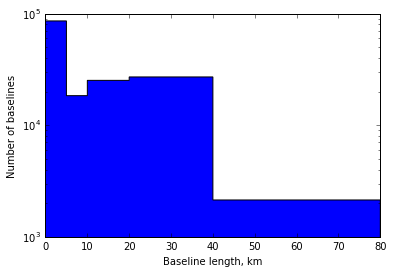

Percentage outputs per bin:  [ 54.13501631  11.58434426  15.8875326   17.04647091   1.34663593]
Bin top edge:  [  5000.  10000.  20000.  40000.  80000.]
[ 85948.  18392.  25224.  27064.   2138.]
[ 54.13501631  11.58434426  15.8875326   17.04647091   1.34663593]
100.0


In [4]:
import numpy as np
import math
import os
import sys
from pylab import *
import matplotlib.pyplot as plt
%matplotlib inline

def readcol(filename,col_number,comment='#'):
        """
        read in a file
        """
        f    = open(filename,'r')
        line = f.readline()

        column = []
        while line:
                columns = line.split()
                column.append(float(columns[col_number-1]))
                line = f.readline()
        f.close()
        return(column)

telescope='LOW' #choose telescope
use_given_bins=True #either use baseline bins matching those currently in the main parametric model or creat new ones..."
binning_type='linear' #and if you make new ones, have either 'linear' or 'log' spacing. 


if telescope=='LOW':
    #config_reader_file=os.getcwd()+'/Reference_Layouts/LOW_LONG_LAT_ECP.wgs84.753x4.txt'
    config_reader_file=os.getcwd()+'/Reference_Layouts/full_array_4a_1m.wgs84.564x4.txt'
    baseline_bins = np.array((0, 80.0/16.0, 80.0/8.0, 80.0/4.0, 80.0/2.0, 80.0))

elif telescope=='MID':
    config_reader_file=os.getcwd()+'/Reference_Layouts/Rebaselined_15July2015_SKA-SA.wgs84.197x4.txt'
    #baseline_bins = np.array((0, 4.4, 6.7, 10.3, 15.7, 24.0, 36.7, 56.0, 85.6, 130.8, 150))
    baseline_bins = np.array((0, 150.0/32.0, 150.0/16.0, 150.0/8.0, 150.0/4.0, 150.0/2.0, 150))

dish_longitude=readcol(config_reader_file, 2)
dish_latitude=readcol(config_reader_file, 3)
dish_diameter=readcol(config_reader_file, 1)
Rearth=6371010.0/1000.0
Number_positions=int(len(dish_diameter)-1)
print "Number of positions in file", Number_positions

array_long_centre=dish_longitude[Number_positions]
array_lat_centre=dish_latitude[Number_positions]
array_centre_diameter=dish_diameter[Number_positions]

print "array_long_centre", array_long_centre
print "array_lat_centre", array_lat_centre
if array_centre_diameter!=0.0: print "array_centre_diameter", array_centre_diameter, '(should be zero, just a check)'

degtorad=2.0*math.pi/360.0

#get x,y,z cartesian coordinates for positions (assuming they sit on a sphere of radius Rearth)
array_x_centre=Rearth*math.cos(array_lat_centre*degtorad)*math.cos(array_long_centre*degtorad)
array_y_centre=Rearth*math.cos(array_lat_centre*degtorad)*math.sin(array_long_centre*degtorad)
array_z_centre=Rearth*math.sin(array_lat_centre*degtorad)
print "Filename used for configuration: ", os.path.basename(config_reader_file)
print "Number of positions in file", Number_positions
Array_dx=[]
Array_dy=[]
Array_dz=[]
Array_r=[]
Baseline_lengths_absolute=[]
for i in range(Number_positions):
	Array_dx.append(Rearth*math.cos(dish_latitude[i]*degtorad)*math.cos(dish_longitude[i]*degtorad)-array_x_centre)
	Array_dy.append(Rearth*math.cos(dish_latitude[i]*degtorad)*math.sin(dish_longitude[i]*degtorad)-array_y_centre)
	Array_dz.append(Rearth*math.sin(dish_latitude[i]*degtorad)-array_z_centre)
	Array_r.append(math.sqrt(Array_dx[i]**2+Array_dy[i]**2+Array_dz[i]**2))
        
"""
Absolute lengths of each baseline are calculated for every possible pairing in the array.
This is very conservative and gives the worst possible case for input baseline lengths going into the performance model.
But, it is trivial to calculate! File arrangements are as generated by iantconfig (by the very talented Matteiu De Villiers).
see http://public.ska.ac.za/software/iantconfig
"""


for i in range(Number_positions):
    for j in range(Number_positions):
        if j > i:
            #For Baseline dependent averaging work, look at the absolute baseline lengths only
            a=(Array_dx[j]-Array_dx[i])
            b=(Array_dy[j]-Array_dy[i])
            c=(Array_dz[j]-Array_dz[i])
            blength_absolute=(math.sqrt(a**2 + b**2 + c**2))
            Baseline_lengths_absolute.append(blength_absolute)

# create a histogram by providing the bin edges (unequally spaced)
#

if use_given_bins:
    bins=baseline_bins
else:
 nbins=50
 bmax=0.8
 bmin=0.01
 bin_number=range(nbins)
 bins=bin_number
 for i in range(nbins):
        if binning_type=="log":
            cutoff=bmin*10**(log10(bmax/bmin)*float(i)/float(nbins))
        elif binning_type=="linear":
            cutoff=bmin+float(i)*(bmax-bmin)/nbins
        else: print "Binning type is not defined"
        bins[i]=(cutoff)

print "Bins used: ", len(bins)
n, bins, patches = hist(Baseline_lengths_absolute, bins, normed=False, histtype='stepfilled')
plt.ylabel('Number of baselines')
plt.xlabel('Baseline length, km')
plt.yscale('log')
plt.show()
#print n
#print sum(n)
print "Percentage outputs per bin: ",100.0*n/sum(n)
print "Bin top edge: ", 1000.0*bins[1:]
print n
percents=100*n/sum(n)
print percents
print sum(percents)
